In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os

movie = 'cars-2.mp4'
CLIP_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/"
MOVIES_DIR = "/om2/data/public/braintreebank_movies/"

clip_features_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_clip_features.npy'))
timestamps_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_timestamps.npy'))
movie_path = os.path.join(MOVIES_DIR, movie)

clip_features = np.load(clip_features_path)  # shape: (num_samples, feature_dim)
timestamps = np.load(timestamps_path)

In [23]:
clip_features_path

'/om2/data/public/braintreebank_movies_clip_preprocessed_2/cars-2_clip_features.npy'

In [24]:
clip_features

array([[-0.01311 , -0.02298 , -0.04947 , ...,  0.06744 , -0.03183 ,
        -0.02565 ],
       [-0.0131  , -0.02304 , -0.04938 , ...,  0.0674  , -0.03183 ,
        -0.0256  ],
       [-0.0131  , -0.02304 , -0.04938 , ...,  0.0674  , -0.03183 ,
        -0.0256  ],
       ...,
       [-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ],
       [-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ],
       [-0.013054, -0.023   , -0.0494  , ...,  0.0675  , -0.03183 ,
        -0.0256  ]], dtype=float16)

Unique values at first index:
[-0.1108  -0.109   -0.1087  ...  0.0758   0.07684  0.0778 ]


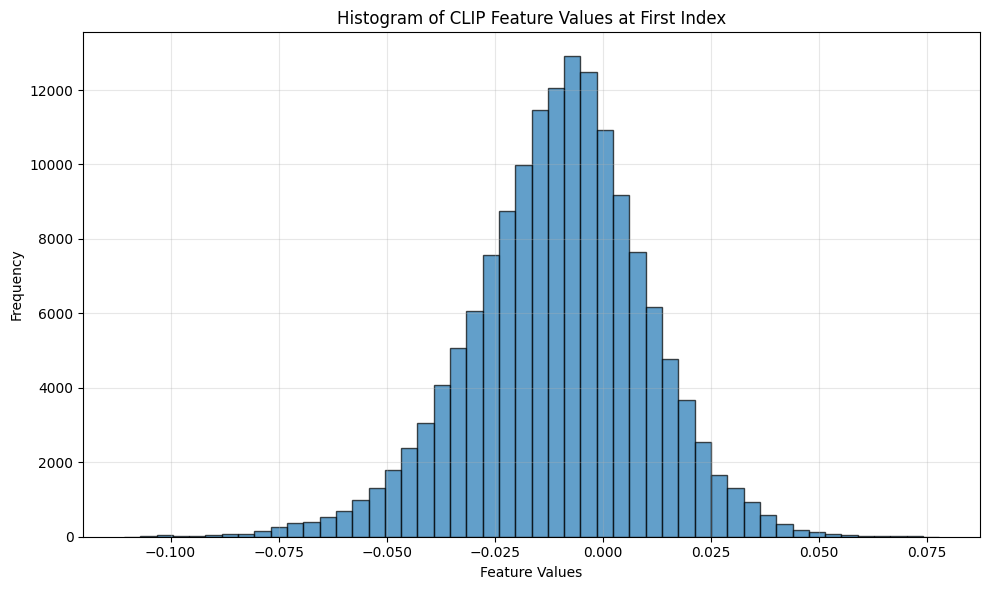

In [25]:
print("Unique values at first index:")
print(np.unique(clip_features[:, 0]))

# Also plot histogram for better visualization
plt.figure(figsize=(10, 6))
plt.hist(clip_features[:, 0], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.title('Histogram of CLIP Feature Values at First Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Computing frame distances...
Detecting scene changes...
Generating visualizations...

Scene Analysis Summary:
Total scenes detected: 3101
Number of scene changes: 3100
Average scene duration: 2.06 seconds
Median scene duration: 1.25 seconds
Shortest scene: 0.08 seconds
Longest scene: 29.90 seconds

Scene change timestamps: ['1.67s', '31.57s', '31.66s', '31.74s', '32.07s', '35.12s', '44.25s', '46.34s', '46.50s', '48.72s', '50.59s', '50.80s', '50.97s', '51.05s', '52.72s', '54.72s', '54.85s', '54.97s', '55.89s', '56.06s', '56.14s', '57.77s', '59.89s', '60.19s', '64.36s', '68.78s', '69.99s', '70.61s', '70.70s', '70.95s', '72.45s', '72.57s', '72.70s', '73.16s', '74.53s', '74.82s', '75.03s', '76.74s', '79.00s', '79.37s', '80.12s', '80.62s', '80.83s', '84.21s', '84.29s', '88.84s', '90.47s', '90.76s', '102.23s', '104.02s', '105.61s', '107.44s', '108.32s', '109.86s', '109.98s', '116.12s', '121.41s', '123.16s', '126.38s', '127.34s', '130.76s', '137.43s', '139.43s', '141.18s', '144.23s', '145.15s

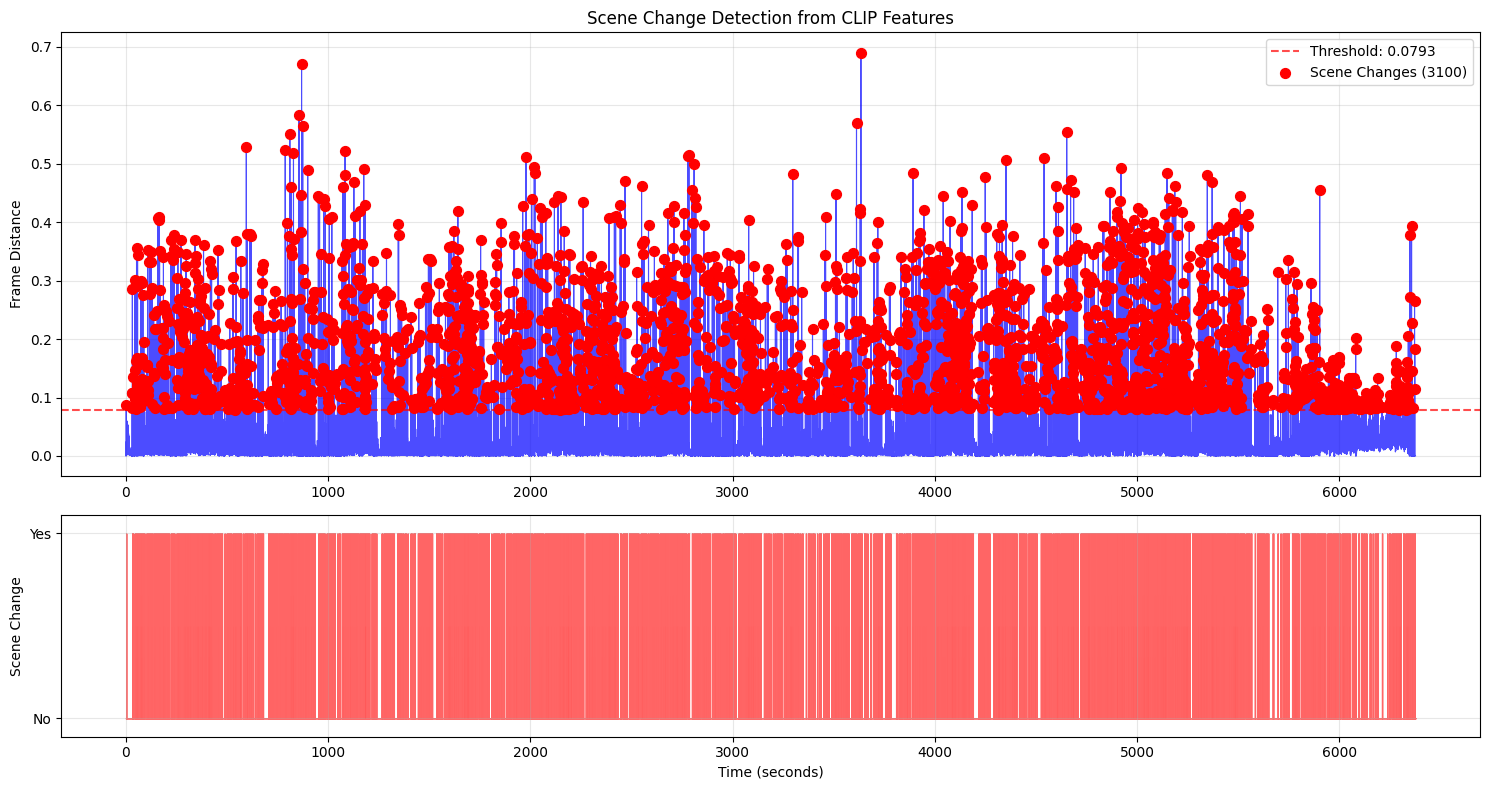

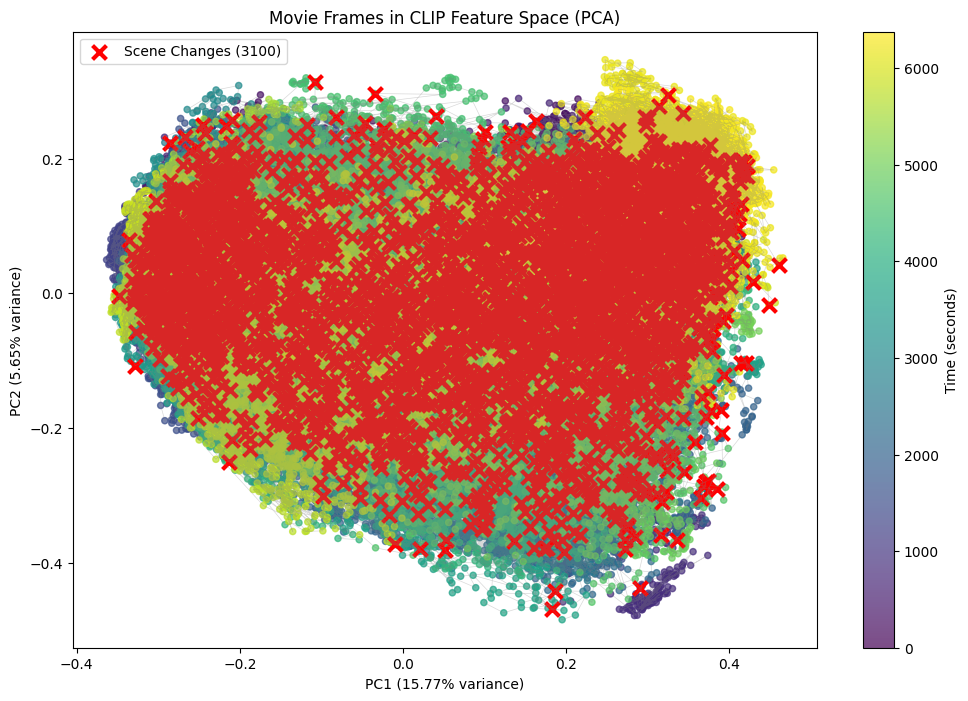

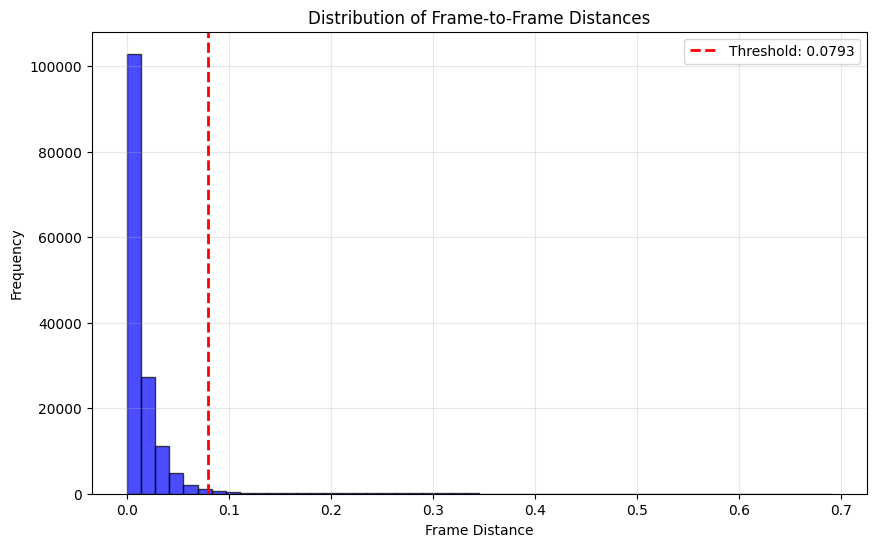

In [26]:
from scipy.signal import find_peaks
from scipy.spatial.distance import cosine, euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

class SceneChangeDetector:
    def __init__(self, clip_features, timestamps):
        self.clip_features = clip_features
        self.timestamps = timestamps
        self.distances = None
        self.scene_changes = None
        
    def compute_frame_distances(self, metric='cosine'):
        """Compute distances between consecutive frames"""
        distances = []
        
        for i in range(1, len(self.clip_features)):
            if metric == 'cosine':
                # Cosine distance (1 - cosine similarity)
                dist = cosine(self.clip_features[i-1], self.clip_features[i])
            elif metric == 'euclidean':
                # Euclidean distance
                dist = euclidean(self.clip_features[i-1], self.clip_features[i])
            elif metric == 'l1':
                # L1 (Manhattan) distance
                dist = np.sum(np.abs(self.clip_features[i-1] - self.clip_features[i]))
            
            distances.append(dist)
            
        self.distances = np.array(distances)
        return self.distances
    
    def detect_scene_changes(self, threshold_method='adaptive', threshold=None, 
                           prominence=None, distance=None):
        """Detect scene changes using peak detection"""
        if self.distances is None:
            self.compute_frame_distances()
            
        if threshold_method == 'adaptive':
            # Use mean + k*std as threshold
            threshold = np.mean(self.distances) + 2 * np.std(self.distances)
        elif threshold_method == 'percentile':
            # Use percentile-based threshold
            threshold = np.percentile(self.distances, 95)
        
        # Find peaks in the distance signal
        peaks, properties = find_peaks(
            self.distances, 
            height=threshold,
            prominence=prominence,
            distance=distance
        )
        
        # Convert frame indices to timestamps
        scene_change_times = [self.timestamps[i+1] for i in peaks]  # +1 because distances are offset
        
        self.scene_changes = {
            'frame_indices': peaks + 1,  # +1 to account for distance offset
            'timestamps': scene_change_times,
            'distances': self.distances[peaks],
            'threshold': threshold
        }
        
        return self.scene_changes
    
    def plot_distance_timeline(self, figsize=(15, 8)):
        """Plot the distance timeline with detected scene changes"""
        if self.distances is None:
            self.compute_frame_distances()
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[2, 1])
        
        # Plot 1: Distance over time
        time_points = self.timestamps[1:]  # Skip first timestamp since distances start from frame 1
        ax1.plot(time_points, self.distances, linewidth=0.8, color='blue', alpha=0.7)
        ax1.set_ylabel('Frame Distance')
        ax1.set_title('Scene Change Detection from CLIP Features')
        ax1.grid(True, alpha=0.3)
        
        # Add scene change markers
        if self.scene_changes is not None:
            ax1.axhline(y=self.scene_changes['threshold'], color='red', 
                       linestyle='--', alpha=0.7, label=f"Threshold: {self.scene_changes['threshold']:.4f}")
            ax1.scatter(self.scene_changes['timestamps'], self.scene_changes['distances'], 
                       color='red', s=50, zorder=5, label=f"Scene Changes ({len(self.scene_changes['timestamps'])})")
            ax1.legend()
        
        # Plot 2: Scene change indicators
        scene_indicators = np.zeros(len(time_points))
        if self.scene_changes is not None:
            for idx in self.scene_changes['frame_indices']:
                if idx - 1 < len(scene_indicators):  # -1 because distances array is offset
                    scene_indicators[idx - 1] = 1
        
        ax2.fill_between(time_points, scene_indicators, alpha=0.6, color='red')
        ax2.set_ylabel('Scene Change')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylim(-0.1, 1.1)
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['No', 'Yes'])
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_feature_space_pca(self, figsize=(12, 8)):
        """Visualize features in 2D PCA space with scene changes highlighted"""
        # Apply PCA to reduce dimensionality
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(self.clip_features)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create a color map based on time
        colors = plt.cm.viridis(np.linspace(0, 1, len(features_2d)))
        
        # Plot trajectory through feature space
        ax.plot(features_2d[:, 0], features_2d[:, 1], alpha=0.3, color='gray', linewidth=0.5)
        scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], c=self.timestamps, 
                           cmap='viridis', s=20, alpha=0.7)
        
        # Highlight scene changes
        if self.scene_changes is not None:
            scene_points = features_2d[self.scene_changes['frame_indices']]
            ax.scatter(scene_points[:, 0], scene_points[:, 1], 
                      color='red', s=100, marker='x', linewidth=3, 
                      label=f'Scene Changes ({len(scene_points)})')
            ax.legend()
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        ax.set_title('Movie Frames in CLIP Feature Space (PCA)')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Time (seconds)')
        
        return fig
    
    def plot_distance_histogram(self, figsize=(10, 6)):
        """Plot histogram of frame distances"""
        if self.distances is None:
            self.compute_frame_distances()
            
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.hist(self.distances, bins=50, alpha=0.7, color='blue', edgecolor='black')
        ax.set_xlabel('Frame Distance')
        ax.set_ylabel('Frequency')
        ax.set_title('Distribution of Frame-to-Frame Distances')
        
        if self.scene_changes is not None:
            ax.axvline(x=self.scene_changes['threshold'], color='red', 
                      linestyle='--', linewidth=2, 
                      label=f"Threshold: {self.scene_changes['threshold']:.4f}")
            ax.legend()
        
        ax.grid(True, alpha=0.3)
        return fig
    
    def get_scene_summary(self):
        """Get summary statistics of detected scenes"""
        if self.scene_changes is None:
            return "No scene changes detected yet. Run detect_scene_changes() first."
        
        scene_durations = []
        prev_time = 0
        
        for change_time in self.scene_changes['timestamps']:
            scene_durations.append(change_time - prev_time)
            prev_time = change_time
        
        # Add final scene duration
        scene_durations.append(self.timestamps[-1] - prev_time)
        
        summary = {
            'total_scenes': len(self.scene_changes['timestamps']) + 1,
            'scene_changes': len(self.scene_changes['timestamps']),
            'avg_scene_duration': np.mean(scene_durations),
            'median_scene_duration': np.median(scene_durations),
            'shortest_scene': np.min(scene_durations),
            'longest_scene': np.max(scene_durations),
            'scene_change_times': self.scene_changes['timestamps']
        }
        
        return summary

# Example usage:
def analyze_movie_scenes(clip_features, timestamps):
    """Complete analysis pipeline"""
    detector = SceneChangeDetector(clip_features, timestamps)
    
    # Try different distance metrics
    print("Computing frame distances...")
    detector.compute_frame_distances(metric='cosine')  # or 'euclidean', 'l1'
    
    # Detect scene changes
    print("Detecting scene changes...")
    scene_changes = detector.detect_scene_changes(threshold_method='adaptive')
    
    # Generate plots
    print("Generating visualizations...")
    fig1 = detector.plot_distance_timeline()
    fig2 = detector.plot_feature_space_pca()
    fig3 = detector.plot_distance_histogram()
    
    # Print summary
    summary = detector.get_scene_summary()
    print("\nScene Analysis Summary:")
    print(f"Total scenes detected: {summary['total_scenes']}")
    print(f"Number of scene changes: {summary['scene_changes']}")
    print(f"Average scene duration: {summary['avg_scene_duration']:.2f} seconds")
    print(f"Median scene duration: {summary['median_scene_duration']:.2f} seconds")
    print(f"Shortest scene: {summary['shortest_scene']:.2f} seconds")
    print(f"Longest scene: {summary['longest_scene']:.2f} seconds")
    
    if summary['scene_changes'] > 0:
        print(f"\nScene change timestamps: {[f'{t:.2f}s' for t in summary['scene_change_times']]}")
    
    plt.show()
    
    return detector, summary, summary['scene_change_times']

# To use with your data:
detector, summary, scene_change_times = analyze_movie_scenes(clip_features, timestamps)

In [27]:
import cv2
from PIL import Image
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE
from subject.braintreebank import BrainTreebankSubject
import pandas as pd

def extract_frame_at_time(video_path, timestamp):
    """
    Extract a frame from video at a specific timestamp.
    
    Args:
        video_path (str): Path to the video file
        timestamp (float): Timestamp in seconds
    Returns:
        PIL.Image: The extracted frame as PIL Image
    """
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(timestamp * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Warning: Could not extract frame at timestamp {timestamp}")
        return None
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    return pil_image


def obtain_neural_data_index(sub_id, trial_id, movie_times):
    # Data frames column IDs
    start_col, end_col = 'start', 'end'
    trig_time_col, trig_idx_col, est_idx_col, est_end_idx_col = 'movie_time', 'index', 'est_idx', 'est_end_idx'

    # Path to trigger times csv file
    trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')

    trigs_df = pd.read_csv(trigger_times_file)
    # display(trigs_df.head())

    last_t = trigs_df[trig_time_col].iloc[-1]
    assert np.all(movie_times < last_t), "Movie times must be less than the last trigger time"
    
    # Vectorized nearest trigger finding
    start_indices = np.searchsorted(trigs_df[trig_time_col].values, movie_times)
    start_indices = np.maximum(start_indices, 0) # handle the edge case where movie starts right at the word
    
    # Vectorized sample index calculation
    return np.round(
        trigs_df.loc[start_indices, trig_idx_col].values + 
        (movie_times - trigs_df.loc[start_indices, trig_time_col].values) * SAMPLING_RATE
    ).astype(int)

# obtain_neural_data_index(10, 1, np.array([725]))

def get_neural_data_at_index(subject_id, trial_id, electrode, start, end):
    subject = BrainTreebankSubject(subject_id, cache=False)
    neural_data = subject.get_electrode_data(electrode,trial_id,window_from=start, window_to=end)
    return neural_data

# subject_id, trial_id = 10, 1
# subject = BrainTreebankSubject(subject_id, cache=False)
# electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
# amygdala_electrode_locations = {label: location for label, location in electrode_locations.items() if 'amygdala' in location.lower()}
# amygdala_labels = list(amygdala_electrode_locations.keys())
# start = obtain_neural_data_index(10, 1, np.array([0])).item()
# end = obtain_neural_data_index(10, 1, np.array([725])).item()
# get_amygdala_neural_at_index(10, 1, amygdala_labels, end-1, end)

In [7]:
SUBJECT_TRIAL_TO_MOVIE = {
    (1,0): 'fantastic-mr-fox.mp4',
    (1,1): 'the-martian.mp4',
    (1,2): 'thor-ragnarok.mp4',
    (2,0): 'venom.mp4',
    (2,1): 'spider-man-3-homecoming.mp4',
    (2,2): 'guardians-of-the-galaxy.mp4',
    (2,3): 'guardians-of-the-galaxy-2.mp4',
    (2,4): 'avengers-infinity-war.mp4',
    (2,5): 'black-panther.mp4',
    (2,6): 'aquaman.mp4',
    (3,0): 'cars-2.mp4',
    (3,1): 'lotr-1.mp4',
    (3,2): 'lotr-2.mp4',
    (4,0): 'shrek-the-third.mp4',
    (4,1): 'megamind.mp4',
    (4,2): 'incredibles.mp4',
    (5,0): 'fantastic-mr-fox.mp4',
    (6,0): 'megamind.mp4',
    (6,1): 'toy-story.mp4',
    (6,2): 'coraline.mp4',
    (7,0): 'cars-2.mp4',
    (7,1): 'megamind.mp4',
    (8,0): 'sesame-street-episode-3990.mp4',
    (9,0): 'ant-man.mp4',
    (10,0): 'cars-2.mp4',
    (10,1): 'spider-man-far-from-home.mp4',
}

In [28]:
#for ant-man
subject_id, trial_id = 3, 0
subject = BrainTreebankSubject(subject_id, cache=False)
electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
electrodes = list(electrode_locations.keys())
electrodes

['F2Ia1',
 'F2Ia2',
 'F2Ia3',
 'F2Ia4',
 'F2Ia5',
 'F2Ia6',
 'F2Ia7',
 'F2Ia8',
 'F2Ia9',
 'F2Ia10',
 'F2Ia11',
 'F2Ia12',
 'F2Ia13',
 'F2Ia14',
 'F3c1',
 'F3c2',
 'F3c3',
 'F3c4',
 'F3c5',
 'F3c6',
 'F3c8',
 'F3c9',
 'F3c10',
 'F3b1',
 'F3b2',
 'F3b3',
 'F3b4',
 'F3b7',
 'F3b8',
 'F3aOF1',
 'F3aOF2',
 'F3aOF3',
 'F3aOF4',
 'F3aOF5',
 'F3aOF6',
 'F3aOF7',
 'F3aOF8',
 'F3d1',
 'F3d2',
 'F3d3',
 'F3d4',
 'F3d5',
 'F3d6',
 'F3d7',
 'F3d8',
 'F3d9',
 'F3d10',
 'T1aIc1',
 'T1aIc2',
 'T1aIc3',
 'T1aIc4',
 'T1aIc5',
 'T1aIc6',
 'P2a1',
 'P2a2',
 'P2a3',
 'P2a4',
 'P2a5',
 'P2a6',
 'P2a7',
 'P2a8',
 'P2a9',
 'P2a10',
 'T1b1',
 'T1b2',
 'T1b3',
 'T1b4',
 'T1b5',
 'T1b6',
 'T1cIe1',
 'T1cIe2',
 'T1cIe5',
 'T1cIe6',
 'T1cIe7',
 'T1cIe8',
 'T1cIe9',
 'T1cIe10',
 'T1cIe11',
 'T1cIe12',
 'P2b1',
 'P2b3',
 'P2b4',
 'P2b5',
 'P2b6',
 'P2b7',
 'P2b8',
 'P2b9',
 'P2b10',
 'P2b11',
 'P2b12',
 'P2b13',
 'P2b14',
 'P2b15',
 'P2b16',
 'O1aIb1',
 'O1aIb2',
 'O1aIb3',
 'O1aIb4',
 'O1aIb5',
 'O1aIb6',
 'O1aIb7

In [29]:
electrode_locations

{'F2Ia1': 'ctx-lh-lateralorbitofrontal',
 'F2Ia2': 'ctx-lh-lateralorbitofrontal',
 'F2Ia3': 'ctx-lh-lateralorbitofrontal',
 'F2Ia4': 'ctx-lh-lateralorbitofrontal',
 'F2Ia5': 'ctx-lh-lateralorbitofrontal',
 'F2Ia6': 'ctx-lh-lateralorbitofrontal',
 'F2Ia7': 'ctx-lh-lateralorbitofrontal',
 'F2Ia8': 'ctx-lh-parstriangularis',
 'F2Ia9': 'ctx-lh-rostralmiddlefrontal',
 'F2Ia10': 'ctx-lh-rostralmiddlefrontal',
 'F2Ia11': 'ctx-lh-rostralmiddlefrontal',
 'F2Ia12': 'ctx-lh-rostralmiddlefrontal',
 'F2Ia13': 'ctx-lh-rostralmiddlefrontal',
 'F2Ia14': 'ctx-lh-rostralmiddlefrontal',
 'F3c1': 'ctx-lh-parsopercularis',
 'F3c2': 'ctx-lh-parsopercularis',
 'F3c3': 'ctx-lh-parsopercularis',
 'F3c4': 'ctx-lh-parsopercularis',
 'F3c5': 'ctx-lh-parsopercularis',
 'F3c6': 'ctx-lh-parstriangularis',
 'F3c8': 'ctx-lh-parstriangularis',
 'F3c9': 'Unknown',
 'F3c10': 'Unknown',
 'F3b1': 'ctx-lh-parstriangularis',
 'F3b2': 'ctx-lh-parstriangularis',
 'F3b3': 'ctx-lh-parstriangularis',
 'F3b4': 'ctx-lh-parstriangul

In [30]:
print(f"Movie timestamps range: {timestamps[0]:.2f} to {timestamps[-1]:.2f} seconds")
print(f"Number of timestamps: {len(timestamps)}")

trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{subject_id}_trial{trial_id:03}_timings.csv')
trigs_df = pd.read_csv(trigger_times_file)
last_trigger_time = trigs_df['movie_time'].iloc[-1]
print(f"Last trigger time for subject {subject_id}, trial {trial_id}: {last_trigger_time:.2f} seconds")

safe_end_timestamp = min(timestamps[-2], last_trigger_time - 1.0)  # 1 second buffer
print(f"Using safe end timestamp: {safe_end_timestamp:.2f}")

start = obtain_neural_data_index(subject_id, trial_id, np.array([timestamps[0]])).item()
end = obtain_neural_data_index(subject_id, trial_id, np.array([safe_end_timestamp])).item()
print(f"Neural data index range: {start} to {end}")

electrode_data = get_neural_data_at_index(subject_id, trial_id, electrodes[0], start, end)
electrode_data

Movie timestamps range: 0.00 to 6376.38 seconds
Number of timestamps: 152881
Last trigger time for subject 3, trial 0: 5909.95 seconds
Using safe end timestamp: 5908.95
Neural data index range: 723127 to 13579855


tensor([41.4715, 41.2056, 43.0665,  ..., 22.0649, 22.0649, 22.3308])

In [31]:
neural_timestamps = timestamps[timestamps <= safe_end_timestamp]
print(f"Original timestamps length: {len(timestamps)}")
print(f"Neural timestamps length: {len(neural_timestamps)}")
print(f"Neural timestamps range: {neural_timestamps[0]:.2f} to {neural_timestamps[-1]:.2f} seconds")
neural_timestamps

Original timestamps length: 152881
Neural timestamps length: 141674
Neural timestamps range: 0.00 to 5908.95 seconds


array([0.00000000e+00, 4.17083750e-02, 8.34167501e-02, ...,
       5.90886720e+03, 5.90890891e+03, 5.90895062e+03])

In [32]:
scene_change_times_filt = np.array(scene_change_times)[np.array(scene_change_times) <= safe_end_timestamp]
scene_change_indexes = [obtain_neural_data_index(subject_id, trial_id, np.array([t])).item() for t in scene_change_times_filt]
scene_change_indexes

[728488,
 789760,
 789931,
 790100,
 790755,
 797014,
 815700,
 820002,
 820324,
 824866,
 828706,
 829131,
 829454,
 829634,
 833059,
 837155,
 837406,
 837649,
 839563,
 839900,
 840074,
 843382,
 847749,
 848337,
 856897,
 865945,
 868403,
 869684,
 869867,
 870381,
 873456,
 873728,
 873950,
 874894,
 877736,
 878318,
 878760,
 882260,
 886869,
 887656,
 889177,
 890201,
 890640,
 897536,
 897725,
 907038,
 910350,
 910968,
 934467,
 938117,
 941394,
 945136,
 946923,
 950084,
 950357,
 962902,
 973754,
 977324,
 983910,
 985870,
 992884,
 1006526,
 1010656,
 1014219,
 1020484,
 1022350,
 1033201,
 1042481,
 1045927,
 1056934,
 1060539,
 1066170,
 1070713,
 1082920,
 1090488,
 1097254,
 1100237,
 1101608,
 1103919,
 1105475,
 1107692,
 1109212,
 1113667,
 1119369,
 1124079,
 1128083,
 1138773,
 1141742,
 1149116,
 1152458,
 1159354,
 1179422,
 1184987,
 1192431,
 1195676,
 1197721,
 1211288,
 1216272,
 1238713,
 1242655,
 1245645,
 1248716,
 1250591,
 1251703,
 1251957,
 1253152,
 

/tmp/ipykernel_460410/3969592364.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/inimai/anaconda3/envs/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


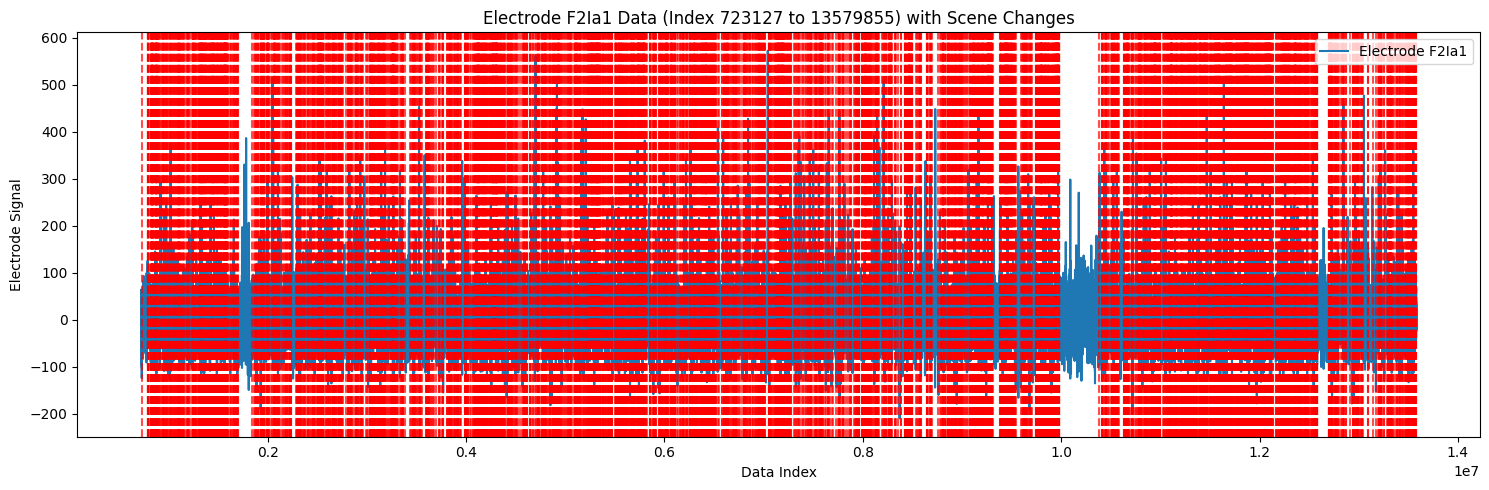

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(range(start, end), electrode_data, label=f'Electrode {electrodes[0]}')
for idx in scene_change_indexes:
    plt.axvline(x=idx, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Data Index')
plt.ylabel('Electrode Signal')
plt.title(f'Electrode {electrodes[0]} Data (Index {start} to {end}) with Scene Changes')
plt.legend()
plt.tight_layout()
plt.show()

723127 827477


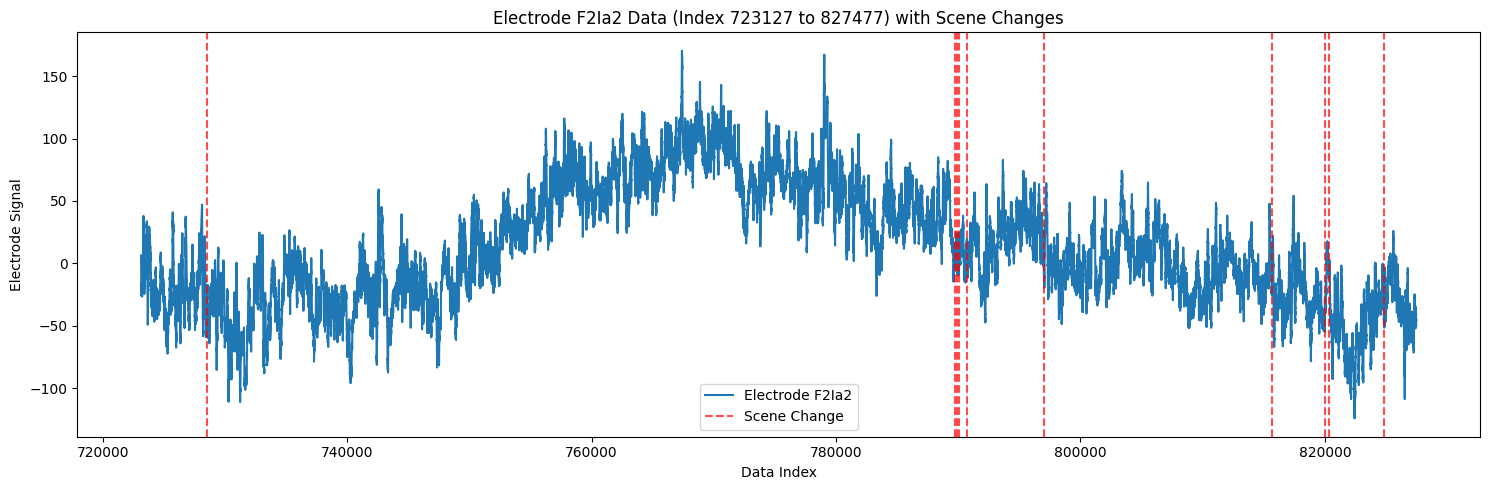

In [34]:
def plot_scene_changes(start_time, end_time, electrode_idx=0):
    start_idx = obtain_neural_data_index(subject_id, trial_id, np.array([start_time])).item()
    end_idx = obtain_neural_data_index(subject_id, trial_id, np.array([end_time])).item()
    scene_idxs = [idx for idx in scene_change_indexes if start_idx <= idx <= end_idx]
    electrode_data_filt = get_neural_data_at_index(subject_id, trial_id, electrodes[electrode_idx], start_idx, end_idx)

    print(start_idx, end_idx)
    
    plt.figure(figsize=(15, 5))
    plt.plot(range(start_idx, end_idx), electrode_data_filt, label=f'Electrode {electrodes[electrode_idx]}')
    for idx in scene_idxs:
        if idx == scene_idxs[0]:
            plt.axvline(x=idx, color='r', linestyle='--', alpha=0.7, label='Scene Change')
        else:
            plt.axvline(x=idx, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Data Index')
    plt.ylabel('Electrode Signal')
    plt.title(f'Electrode {electrodes[electrode_idx]} Data (Index {start_idx} to {end_idx}) with Scene Changes')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_scene_changes(0, 50, 1)

723127 786540


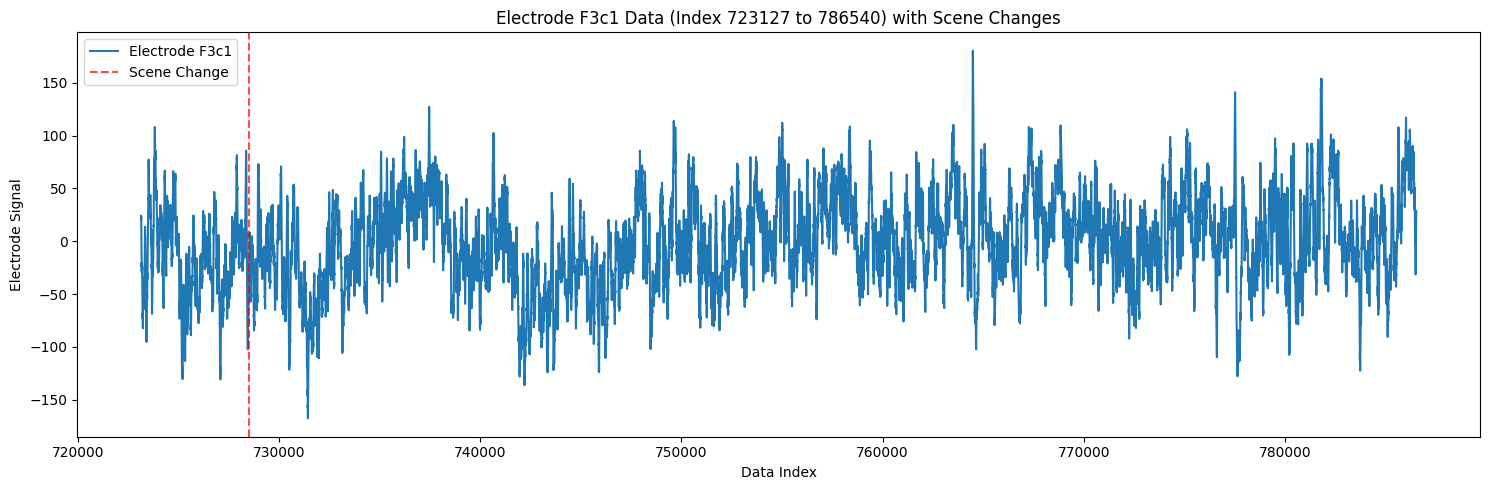

In [35]:
plot_scene_changes(0, 30, 14)

723127 786540


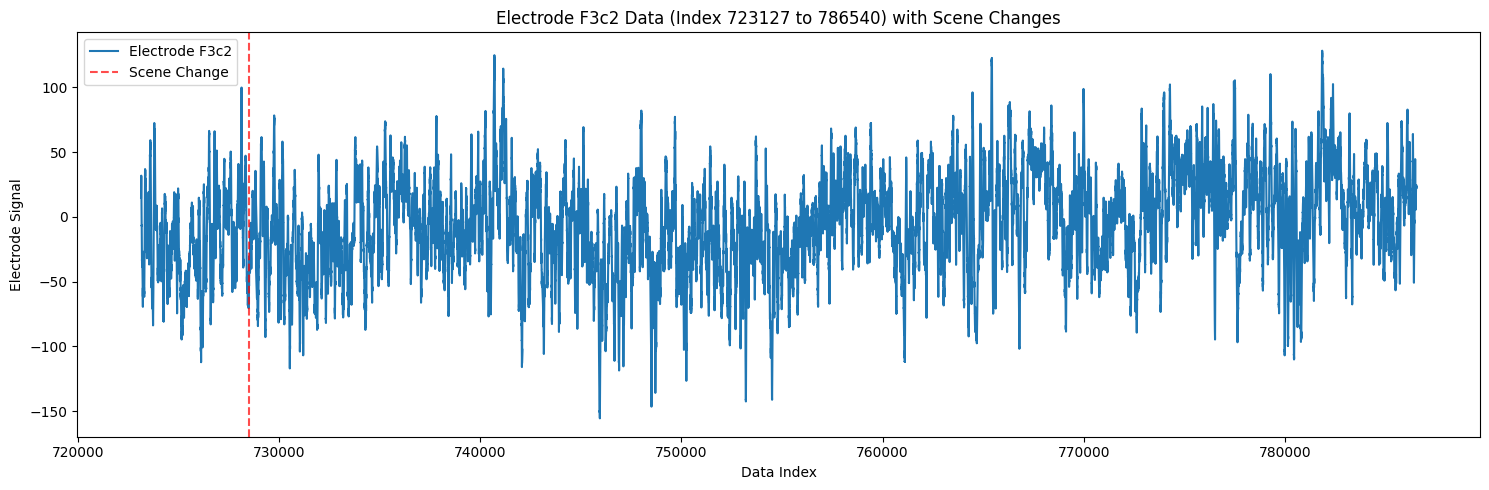

In [36]:
plot_scene_changes(0, 30, 15)

In [37]:
electrode_locations['F3a3']

KeyError: 'F3a3'

723127 786540


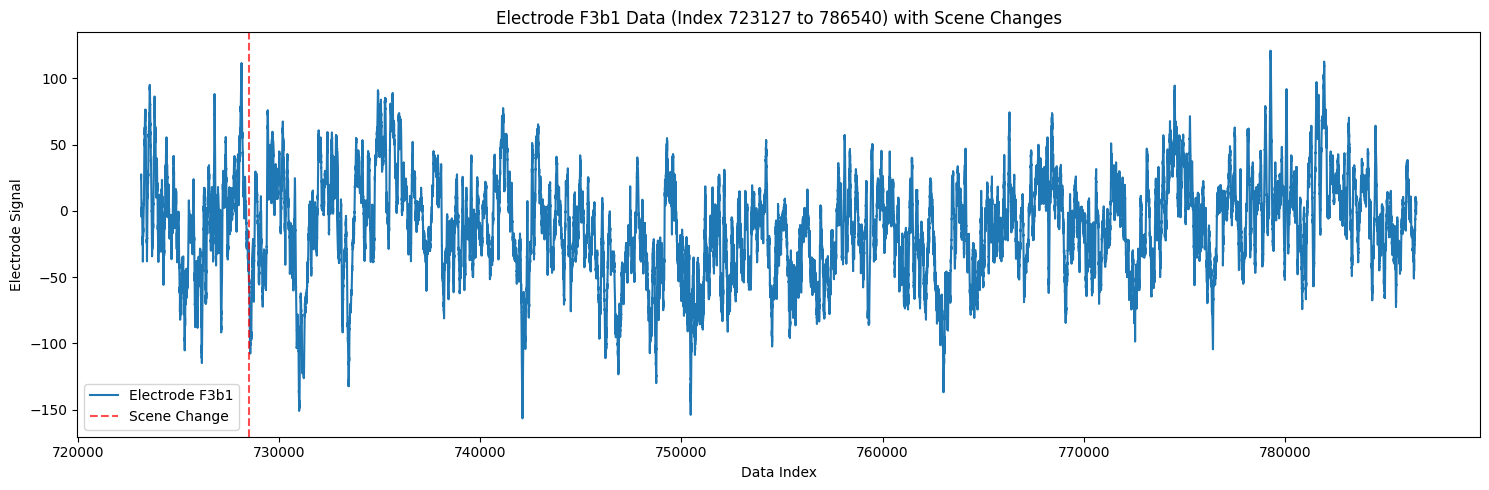

In [38]:
plot_scene_changes(0, 30, 23)

723127 786540


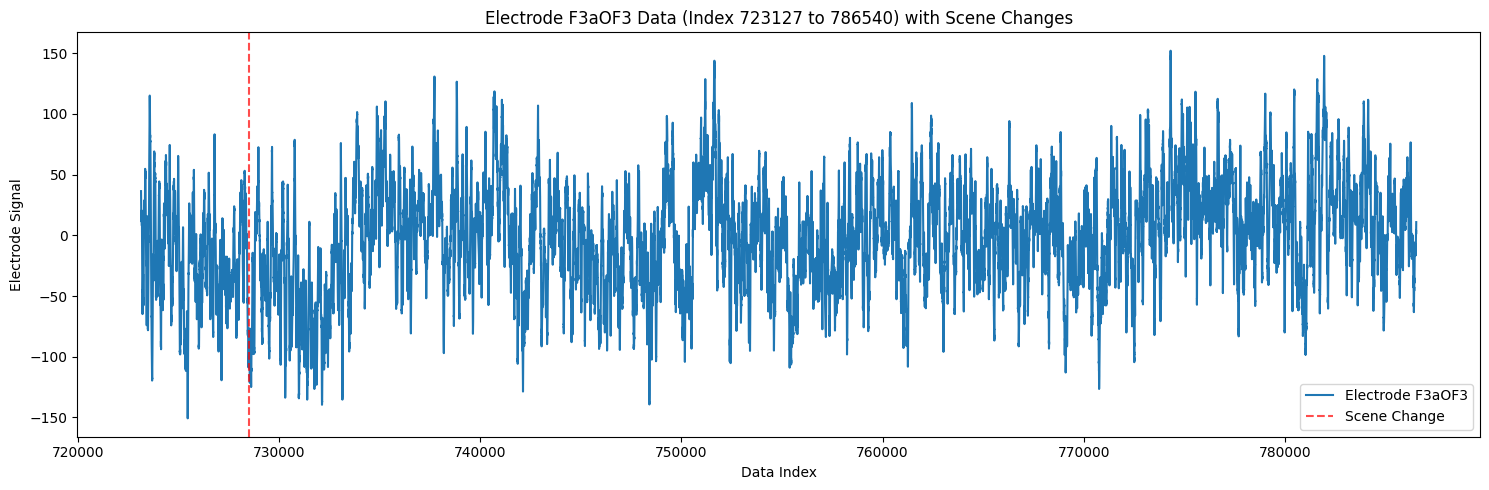

In [39]:
plot_scene_changes(0, 30, 31)

723127 786540


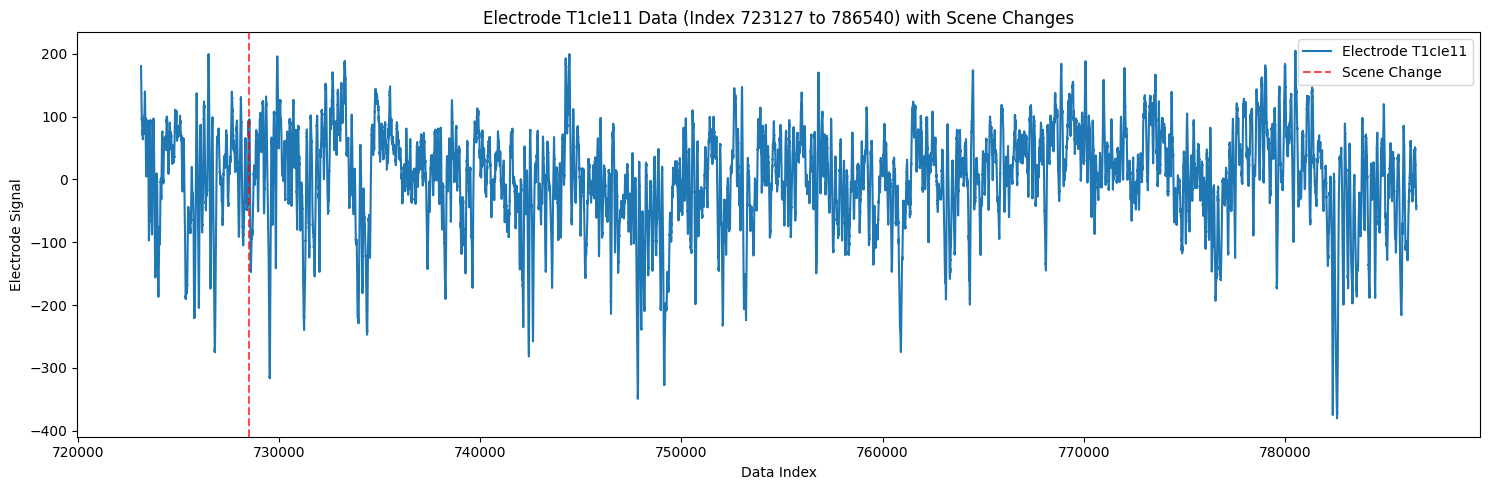

In [40]:
plot_scene_changes(0, 30, 77)

723127 786540


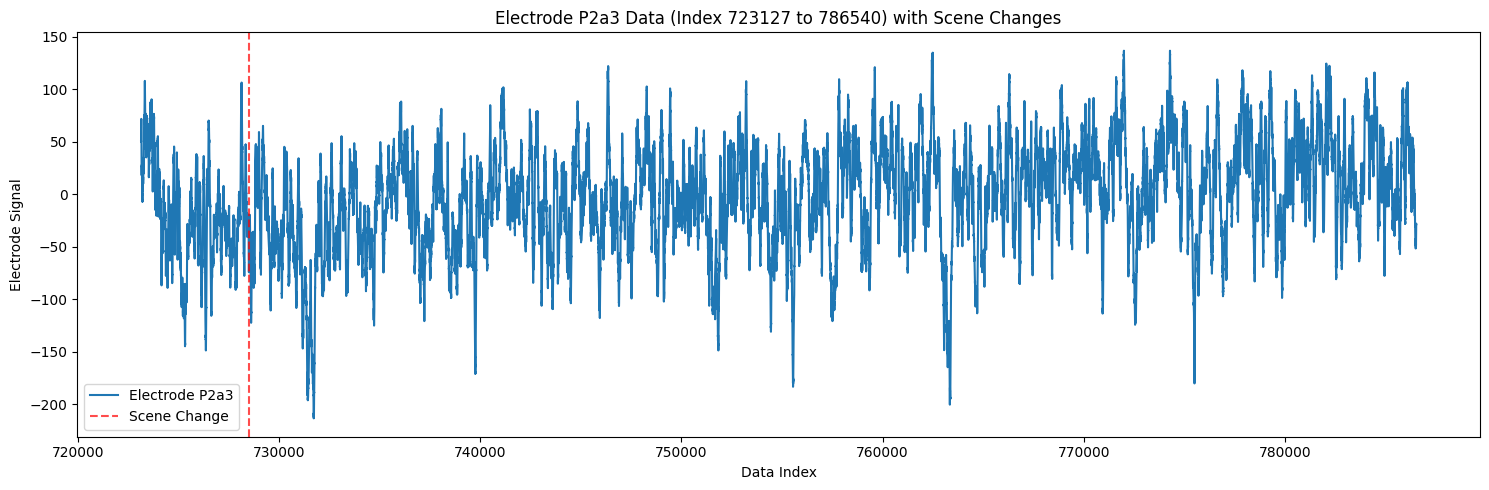

In [41]:
plot_scene_changes(0,30, 55)